# 1. Importación de Librerías

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import cv2
from skimage import exposure
from sklearn.model_selection import train_test_split

import seaborn as sns

In [ ]:
!pip install pygad
import pygad

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 3.7 MB/s eta 0:00:00


# 2. Carga del Dataset

In [ ]:

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Cargar el dataset de escalogramas
def load_dataset(file_path='/content/drive/MyDrive/Tesis/Accelerometer_Dataset/accelerometer_cwt_dataset_ns512_processed.h5'):
    with h5py.File(file_path, 'r') as hf:
        # Cargar datos de entrenamiento
        X_train = np.array(hf['train']['scalograms'])
        y_train = np.array(hf['train']['labels_onehot'])

        # Cargar datos de prueba
        X_test = np.array(hf['test']['scalograms'])
        y_test = np.array(hf['test']['labels_onehot'])

        # Cargar metadatos
        shape = np.array(hf['metadata']['shape'])
        num_classes = np.array(hf['metadata']['num_classes'])

        # Cargar diccionario de etiquetas
        import json
        label_codes_dict = json.loads(hf['metadata'].attrs['label_codes_dict'])

    print(f"Datos cargados: X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"Datos cargados: X_test: {X_test.shape}, y_test: {y_test.shape}")
    print(f"Número de clases: {num_classes}")

    return X_train, y_train, X_test, y_test, label_codes_dict, num_classes

X_train, y_train, X_test, y_test, label_codes_dict, num_classes = load_dataset()

KeyboardInterrupt: 

# 3. Preprocesamiento - Creación de ELIS (Enhanced Leak-Induced Scalograms)
## 3.1 Implementación de Non-Local Means (NLM)

In [ ]:
def apply_nlm(image, h=10, template_window_size=7, search_window_size=21):
    """
    Aplica el algoritmo Non-Local Means para reducir ruido

    Args:
        image: Imagen de entrada
        h: Parámetro de filtrado. Mayor valor = más suavizado
        template_window_size: Tamaño de la ventana de comparación
        search_window_size: Tamaño de la ventana de búsqueda

    Returns:
        Imagen con ruido reducido
    """
    # Convertir a uint8 para OpenCV
    normalized_img = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # Aplicar NLM
    denoised = cv2.fastNlMeansDenoising(
        normalized_img,
        None,
        h=h,
        templateWindowSize=template_window_size,
        searchWindowSize=search_window_size
    )

    # Normalizar de nuevo entre 0 y 1
    return denoised / 255.0

## 3.2. Implementación de Adaptive Histogram Equalization (AHE)

In [ ]:
def apply_clahe(image, clip_limit=2.0, grid_size=(8, 8)):
    """
    Aplica Contrast Limited Adaptive Histogram Equalization (CLAHE)

    Args:
        image: Imagen de entrada
        clip_limit: Límite de contraste
        grid_size: Tamaño de la cuadrícula

    Returns:
        Imagen con contraste mejorado
    """
    # Convertir a uint8 para OpenCV
    normalized_img = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # Crear objeto CLAHE
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=grid_size)

    # Aplicar CLAHE
    equalized = clahe.apply(normalized_img)

    # Normalizar de nuevo entre 0 y 1
    return equalized / 255.0

## 3.3. Generación de ELIS

In [ ]:
def generate_elis(scalograms):
    """
    Genera ELIS (Enhanced Leak-Induced Scalograms) aplicando NLM y AHE

    Args:
        scalograms: Array de escalogramas de forma [batch, height, width, channels]

    Returns:
        ELIS: Escalogramas mejorados
    """
    print("Generando ELIS...")
    elis = np.zeros_like(scalograms)

    for i in range(len(scalograms)):
        if i % 1000 == 0:
            print(f"Procesando escalograma {i}/{len(scalograms)}")

        # Obtener escalograma individual y eliminar dimensión de canal
        scalogram = np.squeeze(scalograms[i])

        # Aplicar Non-Local Means para reducir ruido
        denoised = apply_nlm(scalogram)

        # Aplicar CLAHE para mejorar contraste
        enhanced = apply_clahe(denoised)

        # Restaurar dimensión de canal
        elis[i] = enhanced.reshape(scalogram.shape + (1,))

    return elis

# Generar ELIS para los conjuntos de entrenamiento y prueba
X_train_elis = generate_elis(X_train)
X_test_elis = generate_elis(X_test)

Generando ELIS...
Procesando escalograma 0/48000
Procesando escalograma 1000/48000
Procesando escalograma 2000/48000
Procesando escalograma 3000/48000
Procesando escalograma 4000/48000
Procesando escalograma 5000/48000
Procesando escalograma 6000/48000
Procesando escalograma 7000/48000
Procesando escalograma 8000/48000
Procesando escalograma 9000/48000
Procesando escalograma 10000/48000
Procesando escalograma 11000/48000
Procesando escalograma 12000/48000
Procesando escalograma 13000/48000
Procesando escalograma 14000/48000
Procesando escalograma 15000/48000
Procesando escalograma 16000/48000
Procesando escalograma 17000/48000
Procesando escalograma 18000/48000
Procesando escalograma 19000/48000
Procesando escalograma 20000/48000
Procesando escalograma 21000/48000
Procesando escalograma 22000/48000
Procesando escalograma 23000/48000
Procesando escalograma 24000/48000
Procesando escalograma 25000/48000
Procesando escalograma 26000/48000
Procesando escalograma 27000/48000
Procesando esca

## 3.4. Visualización de ELIS

In [ ]:
def visualize_elis(elis, labels, label_codes_dict, num_per_class=2, fs=25600, segment_size=512):
    """
    Visualiza los ELIS (Enhanced Leak-Induced Scalograms) de manera similar a plot_cwt_scalograms.

    Args:
        elis: Array de escalogramas ELIS
        labels: Array de etiquetas correspondientes
        label_codes_dict: Diccionario que mapea códigos a nombres de etiquetas
        num_per_class: Número de escalogramas a mostrar por clase
        fs: Frecuencia de muestreo
        segment_size: Tamaño del segmento
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.colors import LogNorm

    # Obtener etiquetas únicas
    unique_labels = np.unique(labels)

    # Calcular distribución de subplots
    num_classes = len(unique_labels)
    total_plots = num_classes * num_per_class
    rows = int(np.ceil(total_plots / 3))  # Máximo 3 columnas
    cols = min(3, total_plots)

    # Parámetros para graficar
    t_duration = segment_size / fs  # Duración del segmento en segundos

    # Crear figura
    plt.figure(figsize=(15, 4*rows))

    # Índice actual del subplot
    plot_idx = 1

    # Para cada clase de etiqueta
    for label_code in unique_labels:
        # Encontrar índices donde aparece esta etiqueta
        if len(labels.shape) > 1:  # Si labels está en formato one-hot
            class_indices = [i for i, l in enumerate(labels) if np.argmax(l) == label_code]
        else:
            class_indices = [i for i, l in enumerate(labels) if l == label_code]

        # Seleccionar índices aleatorios si tenemos suficientes muestras
        import random
        if len(class_indices) >= num_per_class:
            selected_indices = random.sample(class_indices, num_per_class)
        else:
            selected_indices = class_indices

        # Graficar ELIS seleccionados
        for idx in selected_indices:
            # Obtener ELIS
            elis_img = np.squeeze(elis[idx])  # Eliminar dimensión de canal si existe

            # Dimensiones del ELIS
            num_freqs, num_times = elis_img.shape

            # Crear ejes de tiempo y frecuencia
            t = np.linspace(0, t_duration, num_times)

            # Crear eje de frecuencia logarítmico (de mayor a menor)
            f0 = 1.0  # Frecuencia mínima
            f1 = fs/2  # Frecuencia máxima (Nyquist)
            freqs = np.geomspace(f1, f0, num_freqs)

            # Crear subplot
            ax = plt.subplot(rows, cols, plot_idx)

            # Graficar usando pcolormesh
            pcm = ax.pcolormesh(t, freqs, elis_img, shading='auto')

            # Configurar escala logarítmica para frecuencias
            ax.set_yscale('log')

            # Obtener nombre de etiqueta
            if isinstance(label_code, int):
                label_name = list(label_codes_dict.keys())[list(label_codes_dict.values()).index(label_code)]
            else:
                label_name = label_code

            # Configurar títulos y etiquetas
            ax.set_title(f"ELIS - {label_name}")
            ax.set_xlabel('Tiempo (s)')
            ax.set_ylabel('Frecuencia (Hz)')

            # Añadir barra de colores
            plt.colorbar(pcm, ax=ax, label='Energía')

            # Incrementar índice de subplot
            plot_idx += 1

    plt.tight_layout()
    plt.show()

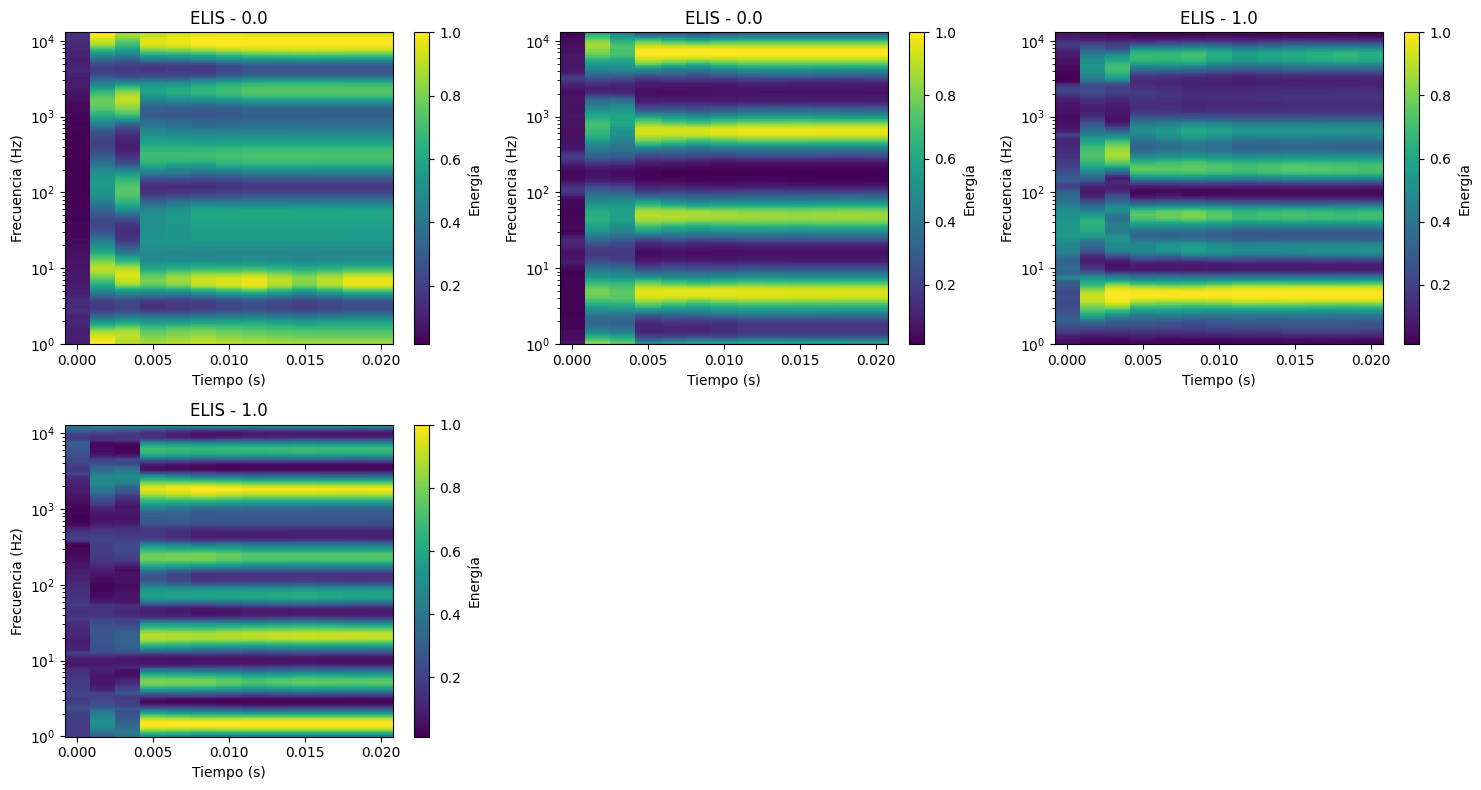

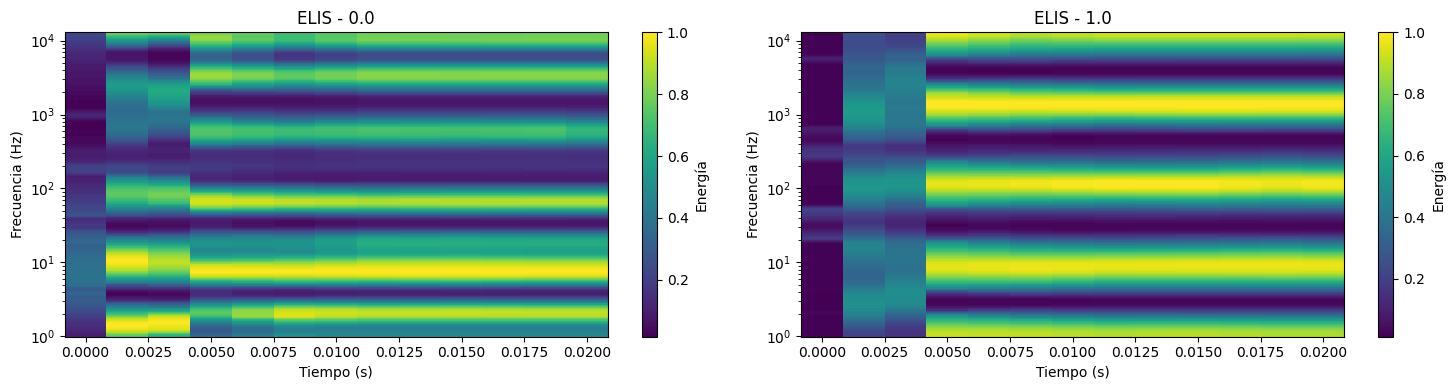

In [ ]:
# Visualizar ELIS representativos (2 por clase) del conjunto de entrenamiento
visualize_elis(
    X_train_elis,       # Array de ELIS de entrenamiento
    y_train,            # Etiquetas correspondientes
    label_codes_dict,   # Diccionario de códigos de etiquetas
    num_per_class=2     # 2 ejemplos por clase
)

# Si también quieres visualizar ELIS del conjunto de prueba
visualize_elis(
    X_test_elis,        # Array de ELIS de prueba
    y_test,             # Etiquetas correspondientes
    label_codes_dict,   # Diccionario de códigos de etiquetas
    num_per_class=1     # 1 ejemplo por clase
)

## 3.5 Salvando los ELIS

In [ ]:
import h5py
import numpy as np
import json
import time

def save_elis_to_h5(X_train_elis, y_train, X_test_elis, y_test, num_classes,
                    label_codes_dict, output_file='accelerometer_cwt_elis_dataset_ns512.h5'):
    """
    Guarda los ELIS ya generados en un archivo H5

    Args:
        X_train_elis: Array de ELIS de entrenamiento
        y_train: Array de etiquetas de entrenamiento
        X_test_elis: Array de ELIS de prueba
        y_test: Array de etiquetas de prueba
        num_classes: Número de clases
        label_codes_dict: Diccionario de códigos de etiquetas
        output_file: Ruta donde guardar el archivo H5
    """
    start_time = time.time()
    print(f"Guardando ELIS en: {output_file}")

    with h5py.File(output_file, 'w') as hf:
        # Crear grupos
        train_group = hf.create_group('train')
        test_group = hf.create_group('test')
        metadata_group = hf.create_group('metadata')

        # Guardar escalogramas ELIS y etiquetas
        train_group.create_dataset('elis', data=X_train_elis)
        train_group.create_dataset('labels_onehot', data=y_train)

        test_group.create_dataset('elis', data=X_test_elis)
        test_group.create_dataset('labels_onehot', data=y_test)

        # Guardar metadatos
        metadata_group.create_dataset('shape', data=X_train_elis.shape[1:])
        metadata_group.create_dataset('num_classes', data=num_classes)

        # Guardar diccionario de etiquetas como atributo
        if label_codes_dict:
            metadata_group.attrs['label_codes_dict'] = json.dumps(label_codes_dict)

        # Guardar información de procesamiento
        processing_info = {
            'nlm_h': 10,
            'nlm_template_window': 7,
            'nlm_search_window': 21,
            'clahe_clip_limit': 2.0,
            'clahe_grid_size': [8, 8]
        }
        metadata_group.attrs['processing_info'] = json.dumps(processing_info)

    elapsed = time.time() - start_time
    print(f"ELIS guardados exitosamente en {output_file}")
    print(f"Tiempo de guardado: {elapsed:.2f} segundos")
    print(f"Dimensiones guardadas - Train: {X_train_elis.shape}, Test: {X_test_elis.shape}")

    return output_file

# Guardar los ELIS generados
output_file = 'accelerometer_cwt_elis_dataset_ns512.h5'
saved_file = save_elis_to_h5(
    X_train_elis,
    y_train,
    X_test_elis,
    y_test,
    num_classes,
    label_codes_dict,
    output_file
)

Guardando ELIS en: accelerometer_cwt_elis_dataset_ns512.h5
ELIS guardados exitosamente en accelerometer_cwt_elis_dataset_ns512.h5
Tiempo de guardado: 22.26 segundos
Dimensiones guardadas - Train: (48000, 512, 13, 1), Test: (12000, 512, 13, 1)


## 3.6 Cargando los ELIS

In [ ]:
def load_elis_dataset(file_path='accelerometer_cwt_elis_dataset_ns512.h5'):
    """
    Carga el dataset de ELIS desde un archivo H5

    Args:
        file_path: Ruta al archivo H5 con los ELIS

    Returns:
        Datos de entrenamiento, prueba y metadatos
    """
    print(f"Cargando dataset ELIS desde: {file_path}")
    with h5py.File(file_path, 'r') as hf:
        # Cargar datos de entrenamiento
        X_train_elis = np.array(hf['train']['elis'])
        y_train = np.array(hf['train']['labels_onehot'])

        # Cargar datos de prueba
        X_test_elis = np.array(hf['test']['elis'])
        y_test = np.array(hf['test']['labels_onehot'])

        # Cargar metadatos
        num_classes = np.array(hf['metadata']['num_classes'])

        # Cargar diccionario de etiquetas
        import json
        if 'label_codes_dict' in hf['metadata'].attrs:
            label_codes_dict = json.loads(hf['metadata'].attrs['label_codes_dict'])
        else:
            label_codes_dict = {}

        # Cargar información de procesamiento
        if 'processing_info' in hf['metadata'].attrs:
            processing_info = json.loads(hf['metadata'].attrs['processing_info'])
        else:
            processing_info = {}

    print(f"Dataset ELIS cargado: X_train: {X_train_elis.shape}, X_test: {X_test_elis.shape}")
    print(f"Número de clases: {num_classes}")

    return X_train_elis, y_train, X_test_elis, y_test, label_codes_dict, num_classes, processing_info

# Cargar ELIS
X_train_elis, y_train, X_test_elis, y_test, label_codes_dict, num_classes, processing_info = load_elis_dataset(file_path='/content/drive/MyDrive/Tesis/Accelerometer_Dataset/accelerometer_cwt_elis_dataset_ns512.h5')

# Mostrar información sobre el procesamiento aplicado
print("\nProcesamiento aplicado para generar ELIS:")
for param, value in processing_info.items():
    print(f"- {param}: {value}")

Cargando dataset ELIS desde: /content/drive/MyDrive/Tesis/Accelerometer_Dataset/accelerometer_cwt_elis_dataset_ns512.h5
Dataset ELIS cargado: X_train: (48000, 512, 13, 1), X_test: (12000, 512, 13, 1)
Número de clases: 5

Procesamiento aplicado para generar ELIS:
- nlm_h: 10
- nlm_template_window: 7
- nlm_search_window: 21
- clahe_clip_limit: 2.0
- clahe_grid_size: [8, 8]


#  4. Implementación del Deep Belief Network (DBN)
## 4.1. Preparación de los datos para la DBN

In [ ]:
def prepare_data_for_dbn(elis):
    """
    Prepara los escalogramas ELIS para la DBN

    Args:
        elis: Array de escalogramas ELIS

    Returns:
        Vector aplanado de escalogramas
    """
    # Obtener dimensiones
    batch_size, height, width, channels = elis.shape

    # Aplanar cada escalograma
    flattened = elis.reshape(batch_size, height * width * channels)

    return flattened

# Preparar datos para DBN
X_train_flat = prepare_data_for_dbn(X_train_elis)
X_test_flat = prepare_data_for_dbn(X_test_elis)

# Normalizar los datos
scaler = StandardScaler()
X_train_flat = scaler.fit_transform(X_train_flat)
X_test_flat = scaler.transform(X_test_flat)

## 4.2. Implementación de la arquitectura DBN

In [ ]:
def create_dbn_model(input_shape, num_classes):
    """
    Crea un modelo DBN según la arquitectura descrita en la Tabla 1 del artículo

    Args:
        input_shape: Forma de la entrada
        num_classes: Número de clases

    Returns:
        Modelo DBN
    """
    # Definir regularizaciones
    l2_reg = regularizers.l2(0.001)

    # Crear modelo
    inputs = keras.Input(shape=(input_shape,))

    # Primera capa densa con regularización L2
    x = layers.Dense(512, kernel_regularizer=l2_reg)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.3)(x)

    # Segunda capa densa con regularización L2
    x = layers.Dense(512, kernel_regularizer=l2_reg)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.3)(x)

    # Tercera capa densa con regularización L2
    x = layers.Dense(256, kernel_regularizer=l2_reg)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.3)(x)

    # Cuarta capa densa con regularización L2
    x = layers.Dense(128, kernel_regularizer=l2_reg)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.3)(x)

    # Quinta capa densa con regularización L2
    x = layers.Dense(64, kernel_regularizer=l2_reg)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.3)(x)

    # Capa de salida para clasificación
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    # Crear y compilar modelo
    dbn_model = keras.Model(inputs, outputs)
    dbn_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return dbn_model

# Crear modelo DBN
input_shape = X_train_flat.shape[1]
# Extract the single integer value from the num_classes array
num_classes_int = num_classes.item()
dbn_model = create_dbn_model(input_shape, num_classes_int)
dbn_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 6656)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       3,408,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │              

 Total params: 3,849,733 (14.69 MB)

 Trainable params: 3,846,789 (14.67 MB)

 Non-trainable params: 2,944 (11.50 KB)

## 4.3. Entrenamiento del modelo DBN

Epoch 1/150
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 110s 83ms/step - accuracy: 0.2155 - loss: 3.3893 - val_accuracy: 0.2317 - val_loss: 2.1611 - learning_rate: 0.0010
Epoch 2/150
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 140s 82ms/step - accuracy: 0.2234 - loss: 2.0434 - val_accuracy: 0.2294 - val_loss: 1.7566 - learning_rate: 0.0010
Epoch 3/150
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 146s 85ms/step - accuracy: 0.2264 - loss: 1.7293 - val_accuracy: 0.2178 - val_loss: 1.6717 - learning_rate: 0.0010
Epoch 4/150
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 141s 85ms/step - accuracy: 0.2177 - loss: 1.6703 - val_accuracy: 0.2315 - val_loss: 1.6483 - learning_rate: 0.0010
Epoch 5/150
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 137s 80ms/step - accuracy: 0.2139 - loss: 1.6513 - val_accuracy: 0.2051 - val_loss: 1.6692 - learning_rate: 0.0010
Epoch 6/150
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 152s 89ms/step - accuracy: 0.2101 - loss: 1.6570 - val_accuracy: 0.2184 - val_loss: 1.7002 - learning_rate: 0.0010
Epoch 7/150
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 93s 77ms/

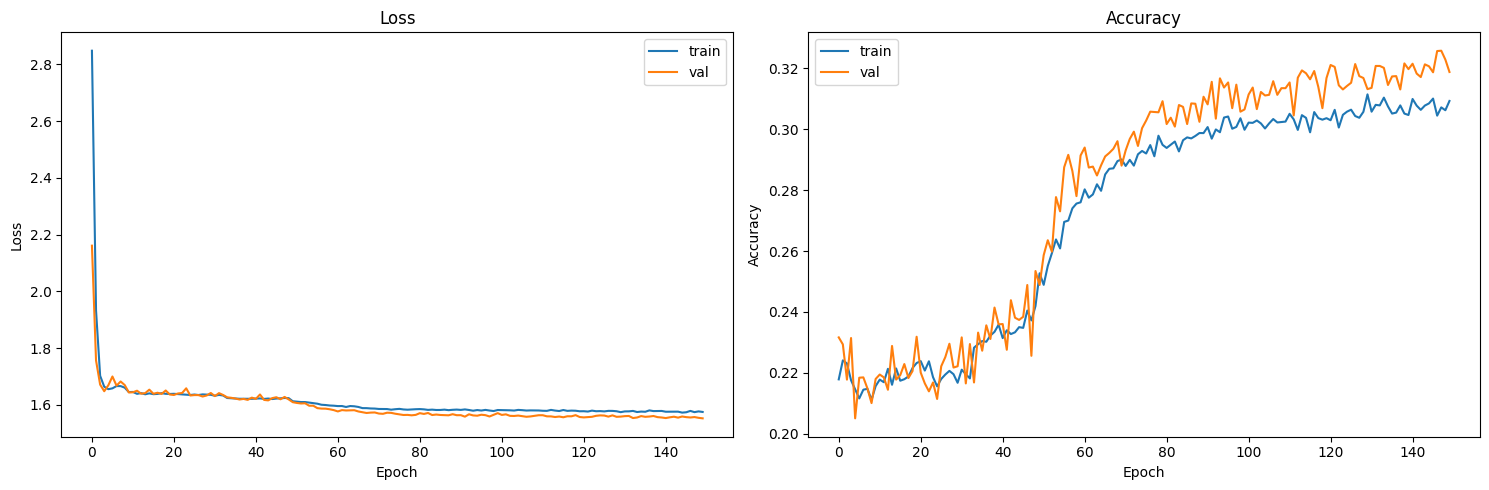

In [ ]:
# Definir callbacks
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.0001
)

from sklearn.model_selection import train_test_split

# Split data into training and validation sets with stratification
X_train_dbn, X_val_dbn, y_train_dbn, y_val_dbn = train_test_split(
    X_train_flat,
    y_train,
    test_size=0.2,
    random_state=42,  # For reproducibility
    stratify=y_train  # Ensures class proportions in both sets
)

# Now use the split datasets for training
history = dbn_model.fit(
    X_train_dbn,
    y_train_dbn,
    epochs=100,
    batch_size=32,
    validation_data=(X_val_dbn, y_val_dbn),  # Use separate validation data
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Visualizar curvas de entrenamiento
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Gráfica de pérdida
    ax1.plot(history.history['loss'], label='train')
    ax1.plot(history.history['val_loss'], label='val')
    ax1.set_title('Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Gráfica de precisión
    ax2.plot(history.history['accuracy'], label='train')
    ax2.plot(history.history['val_accuracy'], label='val')
    ax2.set_title('Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

 ## 4.4. Extracción de características con el modelo DBN

In [ ]:
def extract_dbn_features(model, data):
    """
    Extrae características utilizando un modelo DBN

    Args:
        model: Modelo DBN entrenado
        data: Datos de entrada

    Returns:
        Características extraídas
    """
    # Crear un modelo que devuelve la salida de la penúltima capa
    feature_extractor = keras.Model(
        inputs=model.inputs,
        outputs=model.layers[-2].output  # Penúltima capa (100 neuronas)
    )

    # Extraer características
    features = feature_extractor.predict(data)

    return features

# Extraer características para conjuntos de entrenamiento y prueba
train_features = extract_dbn_features(dbn_model, X_train_flat)
test_features = extract_dbn_features(dbn_model, X_test_flat)

print(f"Características extraídas: {train_features.shape}")

# 5. Reducción de dimensionalidad con t-SNE

Aplicando t-SNE...


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Aplicando t-SNE...


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Forma después de t-SNE: (48000, 2)


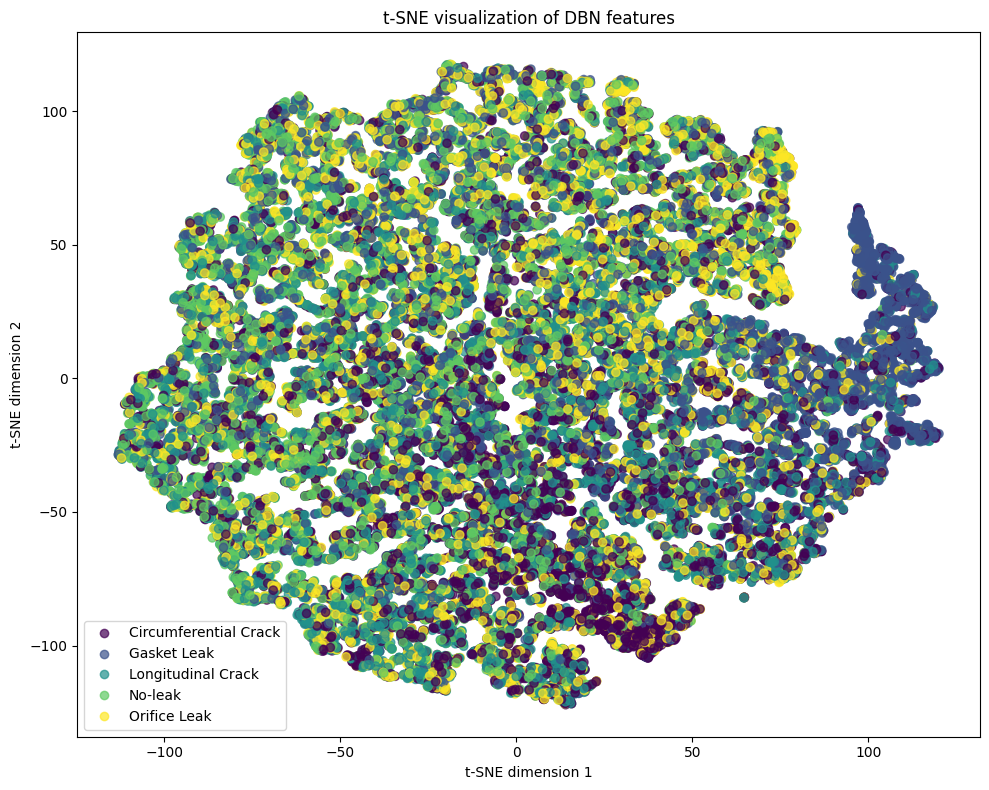

In [ ]:
def apply_tsne(features, n_components=2, perplexity=30, n_iter=1000):
    """
    Aplica t-SNE para reducción de dimensionalidad

    Args:
        features: Características extraídas por DBN
        n_components: Número de componentes de salida
        perplexity: Perplexidad para t-SNE
        n_iter: Número de iteraciones

    Returns:
        Características reducidas
    """
    print("Aplicando t-SNE...")
    tsne = TSNE(
        n_components=n_components,
        perplexity=perplexity,
        n_iter=n_iter,
        random_state=42
    )

    reduced_features = tsne.fit_transform(features)

    return reduced_features

# Aplicar t-SNE a las características
train_reduced = apply_tsne(train_features)
test_reduced = apply_tsne(test_features)

print(f"Forma después de t-SNE: {train_reduced.shape}")

# Visualizar los datos reducidos
def plot_tsne(reduced_features, labels, label_codes_dict):
    """
    Visualiza los datos reducidos por t-SNE
    """
    # Convertir labels one-hot a índices
    if len(labels.shape) > 1:
        labels = np.argmax(labels, axis=1)

    plt.figure(figsize=(10, 8))

    # Crear un scatter plot coloreado por clase
    scatter = plt.scatter(
        reduced_features[:, 0],
        reduced_features[:, 1],
        c=labels,
        cmap='viridis',
        alpha=0.7
    )

    # Añadir leyenda
    legend_labels = [f"{key}" for key, value in label_codes_dict.items()]
    plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels)

    plt.title('t-SNE visualization of DBN features')
    plt.xlabel('t-SNE dimension 1')
    plt.ylabel('t-SNE dimension 2')
    plt.tight_layout()
    plt.show()

# Visualizar resultados de t-SNE
plot_tsne(train_reduced, y_train, label_codes_dict)

# 6. Implementación del clasificador LSSVM
# 6.1. Función para crear y evaluar el modelo LSSVM

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

def create_lssvm(C=1.0, gamma='scale'):
    """
    Crea un modelo LSSVM (aproximado usando SVC con kernel RBF)

    Args:
        C: Parámetro de regularización
        gamma: Parámetro de kernel RBF

    Returns:
        Modelo LSSVM
    """
    # Nota: Scikit-learn no tiene implementación directa de LSSVM,
    # usamos SVC con kernel RBF que es similar conceptualmente
    lssvm = SVC(
        C=C,
        kernel='rbf',
        gamma=gamma,
        probability=True
    )

    return lssvm

def evaluate_lssvm(model, X_train, y_train, X_test, y_test):
    """
    Entrena y evalúa un modelo LSSVM

    Returns:
        Precisión del modelo
    """
    # Convertir etiquetas one-hot a índices
    if len(y_train.shape) > 1:
        y_train = np.argmax(y_train, axis=1)
    if len(y_test.shape) > 1:
        y_test = np.argmax(y_test, axis=1)

    # Entrenar modelo
    model.fit(X_train, y_train)

    # Predecir y evaluar
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy, y_pred

# Crear y evaluar modelo LSSVM inicial
base_lssvm = create_lssvm()
base_accuracy, base_predictions = evaluate_lssvm(
    base_lssvm,
    train_reduced,
    y_train,
    test_reduced,
    y_test
)

print(f"Precisión del modelo LSSVM base: {base_accuracy:.4f}")

# 7. Optimización con Algoritmo Genético

In [ ]:
def fitness_function(solution, solution_idx):
    """
    Función de fitness para evaluar soluciones del algoritmo genético

    Args:
        solution: Lista de parámetros [C, gamma]
        solution_idx: Índice de la solución actual

    Returns:
        Valor de fitness (precisión)
    """
    # Extraer parámetros
    C = solution[0]
    gamma = solution[1]

    # Crear modelo LSSVM con parámetros actuales
    lssvm = create_lssvm(C=C, gamma=gamma)

    # Evaluar modelo con validación cruzada
    X_train_copy = train_reduced.copy()
    y_train_copy = y_train.copy()

    # Dividir datos para validación
    X_train_ga, X_val_ga, y_train_ga, y_val_ga = train_test_split(
        X_train_copy,
        y_train_copy,
        test_size=0.2,
        random_state=42
    )

    # Evaluar modelo
    accuracy, _ = evaluate_lssvm(
        lssvm,
        X_train_ga,
        y_train_ga,
        X_val_ga,
        y_val_ga
    )

    return accuracy

# Definir parámetros del algoritmo genético
ga_instance = pygad.GA(
    num_generations=20,
    num_parents_mating=4,
    sol_per_pop=8,
    num_genes=2,
    fitness_func=fitness_function,
    gene_space=[
        {'low': 0.1, 'high': 10.0},  # Rango para C
        {'low': 0.001, 'high': 1.0}  # Rango para gamma
    ],
    gene_type=float,
    parent_selection_type="tournament",
    K_tournament=3,
    crossover_type="uniform",
    mutation_type="adaptive",
    mutation_probability=[0.25, 0.1]
)

# Ejecutar algoritmo genético
print("Optimizando parámetros del LSSVM con algoritmo genético...")
ga_instance.run()

# Obtener mejor solución
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print(f"Mejor solución encontrada: C={solution[0]:.4f}, gamma={solution[1]:.4f}")
print(f"Fitness: {solution_fitness:.4f}")

# Graficar evolución del algoritmo genético
ga_instance.plot_fitness()

Optimizando parámetros del LSSVM con algoritmo genético...


# 8. Evaluación del modelo final

In [ ]:
# Crear modelo LSSVM optimizado
optimized_lssvm = create_lssvm(C=solution[0], gamma=solution[1])

# Evaluar modelo con los mejores parámetros
final_accuracy, final_predictions = evaluate_lssvm(
    optimized_lssvm,
    train_reduced,
    y_train,
    test_reduced,
    y_test
)

print(f"Precisión del modelo LSSVM optimizado: {final_accuracy:.4f}")

# Convertir etiquetas one-hot a índices para evaluación
y_test_indices = np.argmax(y_test, axis=1)

# Mostrar informe de clasificación
print("\nInforme de clasificación:")
print(classification_report(
    y_test_indices,
    final_predictions,
    target_names=list(label_codes_dict.keys())
))

# Mostrar matriz de confusión
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test_indices, final_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=list(label_codes_dict.keys()),
           yticklabels=list(label_codes_dict.keys()))
plt.xlabel('Predicción')
plt.ylabel('Valor real')
plt.title('Matriz de confusión')
plt.tight_layout()
plt.show()

# Guardando el Modelo para Despliegue en STM32 con STM32CubeAI

## 1. Integración del DBN y LSSVM en un Modelo Unificado

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pickle
import h5py

In [ ]:
class LSSVMLayer(keras.layers.Layer):
    """
    Implementación de LSSVM como capa personalizada de Keras
    """
    def __init__(self, support_vectors, dual_coef, gamma, intercept, classes, **kwargs):
        super(LSSVMLayer, self).__init__(**kwargs)
        self.support_vectors = tf.Variable(
            support_vectors,
            trainable=False,
            dtype='float32',
            name='support_vectors'
        )
        self.dual_coef = tf.Variable(
            dual_coef,
            trainable=False,
            dtype='float32',
            name='dual_coef'
        )
        self.gamma = tf.Variable(
            gamma,
            trainable=False,
            dtype='float32',
            name='gamma'
        )
        self.intercept = tf.Variable(
            intercept,
            trainable=False,
            dtype='float32',
            name='intercept'
        )
        self.n_classes = len(classes)
        self.classes = classes

    def build(self, input_shape):
        super(LSSVMLayer, self).build(input_shape)

    def call(self, inputs):
        # Calcular la distancia cuadrática entre los puntos y los vectores de soporte
        # Expandimos inputs para broadcast
        x_expanded = tf.expand_dims(inputs, axis=1)  # shape: (batch, 1, features)
        sv_expanded = tf.expand_dims(self.support_vectors, axis=0)  # shape: (1, n_sv, features)

        # Calculamos la distancia cuadrática
        squared_diff = tf.reduce_sum(tf.square(x_expanded - sv_expanded), axis=2)  # shape: (batch, n_sv)

        # Aplicamos el kernel RBF: K(x,y) = exp(-gamma * ||x-y||^2)
        rbf_kernel = tf.exp(-self.gamma * squared_diff)  # shape: (batch, n_sv)

        # Multiplicamos por los coeficientes y sumamos el intercepto
        if self.n_classes > 2:  # Caso multiclase
            # Para multiclase: Decision function para cada clase vs. resto
            decision = tf.matmul(rbf_kernel, self.dual_coef) + self.intercept  # shape: (batch, n_classes)
            return decision
        else:  # Caso binario
            decision = tf.matmul(rbf_kernel, tf.reshape(self.dual_coef, [-1, 1])) + self.intercept
            return decision

    def get_config(self):
        config = super(LSSVMLayer, self).get_config()
        config.update({
            'support_vectors': self.support_vectors.numpy().tolist(),
            'dual_coef': self.dual_coef.numpy().tolist(),
            'gamma': self.gamma.numpy().item(),
            'intercept': self.intercept.numpy().tolist(),
            'n_classes': self.n_classes
        })
        return config

## 1.2. Crear Modelo Unificado

In [ ]:
def create_unified_model(dbn_model, lssvm_model, num_classes):
    """
    Crea un modelo unificado que integra tanto el DBN como el LSSVM
    """
    # Obtener los vectores de soporte y coeficientes del LSSVM
    support_vectors = lssvm_model.support_vectors_.astype('float32')

    # Manejar los dual_coef correctamente según sea binario o multiclase
    if num_classes > 2:
        # Para OvR multiclass en scikit-learn
        dual_coef = lssvm_model.dual_coef_.astype('float32')
    else:
        dual_coef = lssvm_model.dual_coef_.ravel().astype('float32')

    gamma = np.float32(lssvm_model._gamma)
    intercept = lssvm_model.intercept_.astype('float32')
    classes = lssvm_model.classes_

    # Crear modelo unificado
    inputs = dbn_model.inputs

    # Tomar la salida de la penúltima capa del DBN (características extraídas)
    x = dbn_model.layers[-2].output

    # Aplicar capa LSSVM
    lssvm_outputs = LSSVMLayer(
        support_vectors=support_vectors,
        dual_coef=dual_coef,
        gamma=gamma,
        intercept=intercept,
        classes=classes,
        name='lssvm_layer'
    )(x)

    # Aplicar softmax para obtener probabilidades
    outputs = layers.Softmax()(lssvm_outputs)

    # Crear modelo
    unified_model = keras.Model(inputs=inputs, outputs=outputs, name='DBN_LSSVM_Unified')

    # Compilar modelo
    unified_model.compile(
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return unified_model

# Crear y verificar el modelo unificado
unified_model = create_unified_model(dbn_model, optimized_lssvm, num_classes)
print("Modelo unificado creado exitosamente.")
unified_model.summary()

## 2. Guardar el Modelo Unificado

In [ ]:
# Guardar modelo en formato H5 para Keras
unified_model.save('dbn_lssvm_leak_detection_model.h5')
print("Modelo unificado guardado en formato H5.")

# Guardar el modelo en formato TensorFlow SavedModel
unified_model.save('dbn_lssvm_leak_detection_savedmodel')
print("Modelo unificado guardado en formato TensorFlow SavedModel.")

# Convertir a TensorFlow Lite para dispositivos con recursos limitados
converter = tf.lite.TFLiteConverter.from_keras_model(unified_model)
# Optimizar para tamaño
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Cuantización para reducir más el tamaño
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
# Datos representativos para cuantización
def representative_dataset_gen():
    for i in range(min(100, len(X_train_flat))):
        yield [np.array([X_train_flat[i]], dtype=np.float32)]
converter.representative_dataset = representative_dataset_gen
tflite_model = converter.convert()

# Guardar modelo TFLite
with open('dbn_lssvm_leak_detection_model.tflite', 'wb') as f:
    f.write(tflite_model)
print("Modelo convertido y guardado en formato TFLite.")

## 3. Validación del Modelo Unificado

In [ ]:
  # Comprobar que el modelo unificado funciona correctamente
y_pred_unified = np.argmax(unified_model.predict(X_test_flat), axis=1)
y_test_indices = np.argmax(y_test, axis=1)

from sklearn.metrics import accuracy_score
unified_accuracy = accuracy_score(y_test_indices, y_pred_unified)
print(f"Precisión del modelo unificado: {unified_accuracy:.4f}")

## 4. Guardar Preprocesamiento para STM32

In [ ]:
# Crear función para guardar parámetros de preprocesamiento
def save_preprocessing_params(scaler):
    """
    Guarda los parámetros del escalador para su uso en STM32
    """
    preprocessing_params = {
        'mean': scaler.mean_.tolist(),
        'scale': scaler.scale_.tolist(),
        'input_shape': X_train_flat.shape[1]
    }

    with open('preprocessing_params.json', 'w') as f:
        import json
        json.dump(preprocessing_params, f, indent=2)

    print("Parámetros de preprocesamiento guardados.")

# Guardar parámetros de preprocesamiento
save_preprocessing_params(scaler)

## 5. Instrucciones para Despliegue en STM32CubeAI

In [ ]:
# Mostrar instrucciones detalladas para el despliegue
instructions = """
# Instrucciones para desplegar el modelo en STM32 usando STM32CubeAI

## Pasos para la implementación:

1. **Preparar el entorno STM32CubeAI:**
   - Instala STM32CubeIDE y la extensión X-CUBE-AI
   - Crea un nuevo proyecto para tu microcontrolador STM32

2. **Importar el modelo:**
   - En STM32CubeIDE, ve a X-CUBE-AI toolchain
   - Importa el archivo 'dbn_lssvm_leak_detection_model.h5'
   - Alternativamente, puedes usar el archivo TFLite si tu versión de STM32CubeAI lo soporta

3. **Configurar los parámetros:**
   - Asegúrate de que la configuración de RAM/Flash se ajuste a tu microcontrolador
   - Configura el nombre del modelo como "DBN_LSSVM"

4. **Preprocesamiento en STM32:**
   - Implementa el preprocesamiento usando los valores en 'preprocessing_params.json'
   - Normaliza las entradas usando media y escala guardadas

5. **Generar código:**
   - Genera el código C para el modelo
   - STM32CubeAI creará archivos .c/.h para la implementación

6. **Integrar en la aplicación principal:**
   - En tu main.c, incluye los encabezados del modelo generado
   - Inicializa el modelo con la función de inicialización generada
   - Preprocesa los datos del escalograma (ELIS)
   - Llama a la función de inferencia con los datos preprocesados
   - Procesa la salida para determinar la clase detectada

7. **Optimizar rendimiento:**
   - Considera usar DMA para las operaciones de I/O
   - Usa la optimización de CPU más alta posible
   - Considera la cuantización INT8 para mejor rendimiento
"""

print(instructions)

## 6. Exportar el Flujo de Procesamiento Completo

In [ ]:
# Guardar una descripción completa del pipeline para referencia
pipeline_description = """
# Pipeline Completo de Detección de Fugas

## 1. Preprocesamiento de Escalogramas (ELIS)
- Aplicar Non-Local Means (NLM) para reducir ruido
- Aplicar Adaptive Histogram Equalization (CLAHE) para mejorar contraste

## 2. Extracción de Características (DBN)
- Aplanar y normalizar escalogramas ELIS
- Pasar por el modelo DBN para extraer características

## 3. Clasificación (LSSVM)
- Utilizar el modelo LSSVM para clasificar las características
- Obtener la clase predicha (tipo de fuga)

## Hiperparámetros Optimizados:
- LSSVM C: {0}
- LSSVM gamma: {1}
""".format(solution[0], solution[1])

with open('detection_pipeline_description.md', 'w') as f:
    f.write(pipeline_description)

print("Descripción del pipeline guardada.")

## 7. Crear una Función de Inferencia para la Prueba

In [ ]:
def process_new_scalogram(scalogram, model, scaler):
    """
    Procesa un nuevo escalograma para la detección de fugas

    Args:
        scalogram: Escalograma de entrada (H x W x C)
        model: Modelo unificado DBN+LSSVM
        scaler: Escalador para normalización

    Returns:
        Clase predicha y probabilidades
    """
    # 1. Preprocesamiento ELIS
    # Reducir ruido con NLM
    denoised = apply_nlm(scalogram)

    # Mejorar contraste con CLAHE
    enhanced = apply_clahe(denoised)

    # 2. Aplanar y normalizar
    flattened = enhanced.reshape(1, -1)
    normalized = scaler.transform(flattened)

    # 3. Inferencia con el modelo unificado
    prediction = model.predict(normalized)[0]
    predicted_class = np.argmax(prediction)

    return predicted_class, prediction

# Ejemplo de uso con un escalograma de prueba
test_idx = 10
test_scalogram = np.squeeze(X_test[test_idx])

predicted_class, probabilities = process_new_scalogram(
    test_scalogram, unified_model, scaler
)

print(f"Clase real: {np.argmax(y_test[test_idx])}")
print(f"Clase predicha: {predicted_class}")
print(f"Probabilidades: {probabilities}")

# Consideraciones adicionales para STM32

In [ ]:
# Calcular y mostrar requerimientos de memoria
def estimate_memory_requirements(model):
    """
    Estima los requerimientos de memoria del modelo
    """
    # Contar parámetros
    total_params = model.count_params()

    # Estimar tamaño del modelo (asumiendo valores de 32 bits)
    model_size_bytes = total_params * 4

    # Estimar RAM necesaria para inferencia (aproximado)
    # Esto es una estimación simplificada
    ram_estimate = model_size_bytes * 0.25  # Aproximadamente 25% del tamaño del modelo

    print(f"Parámetros totales: {total_params:,}")
    print(f"Tamaño estimado del modelo: {model_size_bytes/1024:.2f} KB")
    print(f"RAM estimada para inferencia: {ram_estimate/1024:.2f} KB")

# Estimar requerimientos de memoria
estimate_memory_requirements(unified_model)

print("""
NOTA IMPORTANTE:
Para desplegar este modelo en un microcontrolador STM32, considera las siguientes optimizaciones:

1. Cuantización: Reduce la precisión de los pesos de punto flotante a entero de 8 bits.
2. Poda de modelo: Si es necesario, reduce más el tamaño eliminando conexiones poco importantes.
3. Recomendación de hardware: Para este modelo, se recomienda un STM32 con al menos 512KB de Flash y 128KB de RAM.
4. Funcionamiento por partes: Si la RAM es limitada, considera procesar el modelo por secciones.

El archivo TFLite generado con cuantización INT8 será significativamente más pequeño y eficiente para tu microcontrolador STM32.
""")